## Глобальные задачи:
- Добавить в графовую нейросеть на torch для перестройки и оптимизации графа при помощи ML оптимизацию по константе связи [Вован]
- Написать функцию, которая строит слои нейронной сети по графу на torch
- Провести тестирование гитотез на нейронке с полученным ядром на реальном датасете
- Написать и исследовать другие графовые модели (пример: Курамото с ускорением, матричные модели, O(N)-модель и т д)
- Можно совсем запариться, и исследовать не только последовательные с слои со сквозными и спарс связями, но и рекуренты (типа память, вроде LSTM) или же вообще механизмы внимания
- Создать библиотку со всеми паттернами нейронных сетей, и обучть RL алгоритм самогенерации ядра и действий!

## Локальные задачи:
- Добавить алгоритм перестройки и оптимизации графа методом теплого отжига через отжиг по парметру порядка при константе связи, когда параметр порядка пуассоновского графа той же размерности равен 0.9 (а был сделан отжтиг по константе связи при достижении параметра порядка 0.9) [Андрей]

## Preporation

In [1]:
# Importing libs

import torch
import numpy as np

from tqdm.notebook import tqdm
import sys
from importlib import reload
from time import time

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

import multiprocessing
from psutil import virtual_memory

In [2]:
# For determinizm!

np.random.seed(42)
torch.manual_seed(42)
torch.random.manual_seed(42)
torch.cuda.random.manual_seed_all(42)

In [3]:
# Providing system paths (for local environments)

path = "C:/Users/Admin/Downloads/Python/Kuramoto/"
sys.path.insert(0, path)

# for showing all input in jupyter notebook
np.set_printoptions(threshold=sys.maxsize)

In [4]:
# Avaliable resourses

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 8
RAM GB: 7.9
PyTorch version: 1.10.0
CUDA version: 11.3
cuDNN version: 8200
device: cuda
Thu Nov 18 01:03:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     37MiB /  2048MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-----------------

In [5]:
from GPUtil import showUtilization as gpu_usage

gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  1% |  2% |


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda', index=0)

In [8]:
# Impotring models and utils

import kuramoto_model

from kuramoto_model import KuramotoModel
from kuramoto_model import KuramotoModelNumba
from kuramoto_model import ThermalAnnealing

In [9]:
import utils

from utils import gen_full_connected_graph, gen_full_connected_graph_random_weights
from utils import gen_poisson_graph, gen_poisson_graph_random_weights
from utils import gen_linear_graph, gen_linear_graph_random_weights
from utils import gen_decorated_star
from utils import gen_direct_acyclic_graph, gen_direct_acyclic_graph_random_weights, gen_direct_acyclic_graph_weak_connections

In [10]:
# Reloading models and utils (for debug only)

kuramoto_model = reload(kuramoto_model)
utils = reload(utils)

## Graph visualization part

In [12]:
num_nodes = 100
graph1 = gen_direct_acyclic_graph(np.array([10, 20, 20, 20, 20, 10]), np.array([3, 3, 3, 3, 3]))
graph2 = gen_poisson_graph(num_nodes)
graph3 = gen_full_connected_graph(num_nodes)
graph4 = gen_decorated_star(num_nodes - 1, 1, 0)
graph5 = gen_full_connected_graph_random_weights(num_nodes)
graph6 = gen_poisson_graph_random_weights(num_nodes)
graph7 = gen_direct_acyclic_graph_random_weights(np.array([10, 20, 20, 20, 20, 10]), np.array([3, 3, 3, 3, 3]))
graph8 = gen_direct_acyclic_graph_weak_connections(np.array([10, 20, 20, 20, 20, 10]), np.array([3, 3, 3, 3, 3]))
graph9 = gen_linear_graph(num_nodes)
graph10 = gen_linear_graph_random_weights(num_nodes)

In [13]:
G1 = nx.DiGraph(graph1)
G2 = nx.Graph(graph2)
G3 = nx.Graph(graph3)
G4 = nx.Graph(graph4)

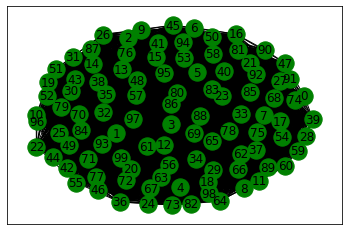

In [14]:
nx.draw_networkx(G3, node_color ='green', with_labels=True)

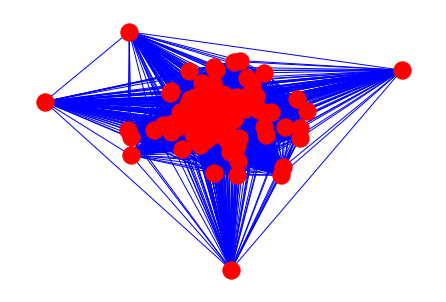

In [15]:
nx.draw(G3, pos=nx.spectral_layout(G3), node_color='r',edge_color='b')

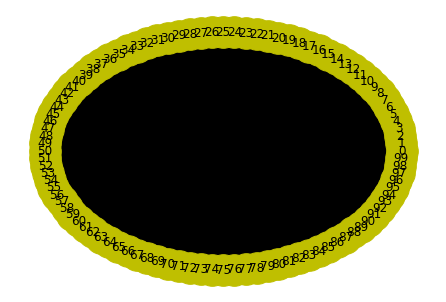

In [16]:
nx.draw_circular(G3, node_color='y', node_size=1000, with_labels=True)

## Testing part

In [17]:
"""Parameters generating"""

adjacency_matrix = torch.tensor(graph3, device=device, dtype=torch.float64)
interaction_consts = torch.tensor([5e-3], device=device, dtype=torch.float64)
freqs = adjacency_matrix.sum(dim=1)
# freqs = torch.tensor([1], device=device, dtype=torch.float64)
initial_phases = 2 * torch.pi * torch.rand(adjacency_matrix.shape[0], device=device, dtype=torch.float64) - torch.pi
timesteps = 10000
thermalization_time = 0

In [18]:
model = KuramotoModel(adjacency_matrix, interaction_consts, freqs, device)

In [19]:
start = time()
result = model.evaluate_(timesteps, initial_phases)
finish = time() - start

print(f"gpu time computing: {finish}")

gpu time computing: 32.04997229576111


In [20]:
model.to(torch.device('cpu'))

In [21]:
model.device

device(type='cpu')

In [22]:
start = time()
result = model.evaluate_(timesteps, initial_phases)
finish = time() - start

print(f"cpu time computing: {finish}")

cpu time computing: 4.550393104553223


In [23]:
result.shape

torch.Size([10000, 100])

In [24]:
# velocities are interesting to be visualized
speeds = model.evolution_func_(timesteps, result)

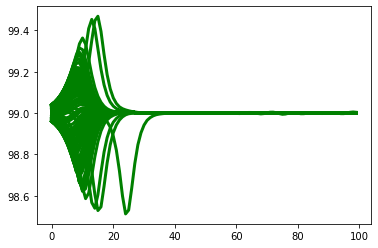

In [25]:
plt.plot(speeds[:100], color='green', linewidth=3) # graphic
plt.show() # display

## Resulting part

In [26]:
# Unicore calculation

num_consts = 3
interaction_consts = 1e-5 + 8e-2 * torch.arange(num_consts, dtype=torch.float64)
model.to(torch.device('cpu'))

start = time()
order_parameters = model.gen_order_parameters_(interaction_consts,
                            timesteps, thermalization_time, initial_phases, method=True)
finish = time() - start

print(f"cpu time computing: {finish}")

cpu time computing: 223.71406531333923


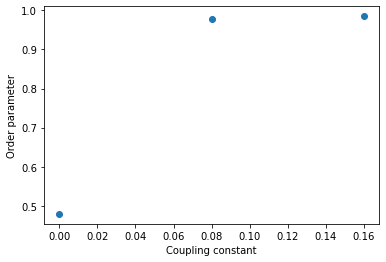

In [27]:
plt.scatter(interaction_consts, order_parameters)
plt.xlabel('Coupling constant')
plt.ylabel('Order parameter')
plt.show()

In [28]:
# Multicore calculation (CPU only!)

num_consts = 3
interaction_consts = 1e-5 + 8e-2 * torch.arange(num_consts, dtype=torch.float64)
model.to(torch.device('cpu'))

start = time()
order_parameters = model.gen_order_parameters_pool(interaction_consts,
                            timesteps, thermalization_time, initial_phases, method=True)
finish = time() - start

print(f"cpu time computing: {finish}")

cpu time computing: 159.99381494522095


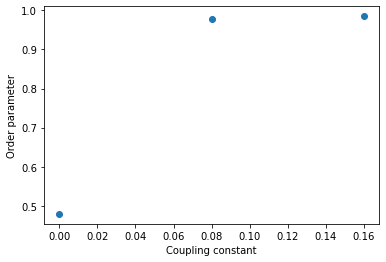

In [29]:
plt.scatter(interaction_consts, order_parameters)
plt.xlabel('Coupling constant')
plt.ylabel('Order parameter')
plt.show()

## Testing Numba part (GPU only!)

## ATTENTION!!!!
1) If you wonna run this part of code on your local GPU device, make sure that you set TDR limit to FALSE mode!!!
<br>
2) Overwise, you will always caught CUDA_TIMEOUT_ERROR, when code computation time greater than 2 seconds (default limitation)
<br>
3) On Windows you can open Nsight monitor in administrator mode and set in menu parameter GENERAL WDDM TDR ENABLED to FALSE
<br>
4) I also reccomend to install NVIDIA Inspector to control sourses
<br>
5) Maximum threads per block is 1024 in Numba, so max num_notes is 1024!

In [34]:
# amount of num_nodes in graph
num_nodes = 32
# amount of blocks in CUDA calculation, each block is responsible for different interaction_const
blocks = 32
# dt for numerical differential equation (DE) solving
dt = 0.1
# amount of timesteps for numerical DE solving
timesteps = 100000
# thermalization time (must be lower then timesteps!)
thermalization_time = 0
# amount of initial condition avereging
stream_num = 1

# generating graph matrix
# adjacency_matrix = gen_decorated_star(num_nodes - 1, 1, 0).astype(np.int8)
# adjacency_matrix = gen_full_connected_graph(num_nodes).astype(np.int8)
adjacency_matrix = gen_poisson_graph(num_nodes, prob=0.7).astype(np.int8)

# setting range of interaction_consts
interaction_consts = 1e-3 + 8e-2 * np.arange(blocks).astype(np.float32)

# setting natural frequencies
# freqs = np.full(num_nodes, 1, dtype=np.int8)
freqs = adjacency_matrix.sum(axis=1)

# creating model
model = KuramotoModelNumba(adjacency_matrix, interaction_consts, freqs)

# generating initial conditions for DE
initial_phases = 2 * np.pi * np.random.rand(stream_num, num_nodes).astype(np.float64) - np.pi

C:\ProgramData\Anaconda3\lib\site-packages\numba\cuda\decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


In [35]:
graph = nx.Graph(adjacency_matrix)

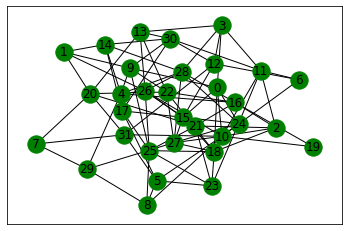

In [36]:
nx.draw_networkx(graph, node_color ='green', with_labels=True)

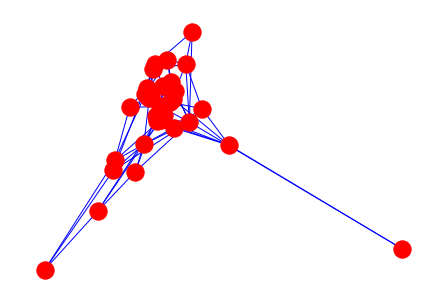

In [37]:
nx.draw(graph, pos=nx.spectral_layout(graph), node_color='r',edge_color='b')

In [39]:
adjacency_matrix[:8, :8]

array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [40]:
# time measuring
start = time()
order_parameters = model.gen_order_parameters_(timesteps, dt, thermalization_time, stream_num, initial_phases)
finish = time() - start

print(f"gpu time computing: {finish}")

gpu time computing: 5.492103815078735


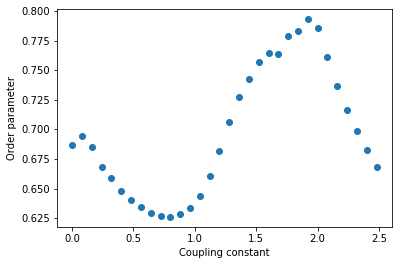

In [41]:
plt.scatter(interaction_consts, order_parameters)
plt.xlabel('Coupling constant')
plt.ylabel('Order parameter')
plt.show()

## Thermal annealing

In [42]:
# Defining annealer, using KuramotoModelNumba as gen_order_parameters function kernel
temperature_change_steps = 10

annealer = ThermalAnnealing(model.gen_order_parameters, interaction_consts, adjacency_matrix, freqs, timesteps,
                            thermalization_time, initial_phases, is_torch_gen=False, threshold=0.7, modify_freqs=True,
                            temperature_change_steps=temperature_change_steps)

In [43]:
# time measuring
start = time()
new_adjacency_matrix, new_freqs, order_parameters_history, converge_interaction_consts_history = annealer.anneal()
finish = time() - start

print(f"gpu time computing: {finish}")

gpu time computing: 55.98241710662842


In [52]:
# order_parameters_history

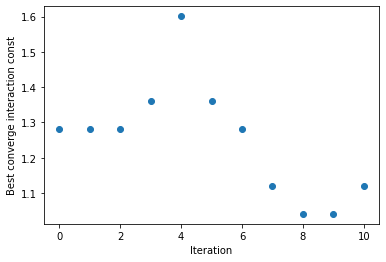

In [45]:
plt.scatter(np.arange(temperature_change_steps + 1), converge_interaction_consts_history)
plt.xlabel('Iteration')
plt.ylabel('Best converge interaction const')
plt.show()

In [46]:
result_graph = nx.Graph(new_adjacency_matrix)

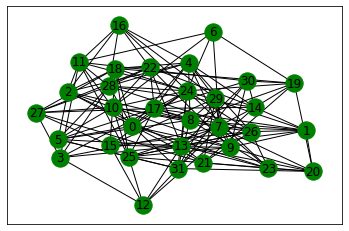

In [47]:
nx.draw_networkx(result_graph, node_color ='green', with_labels=True)

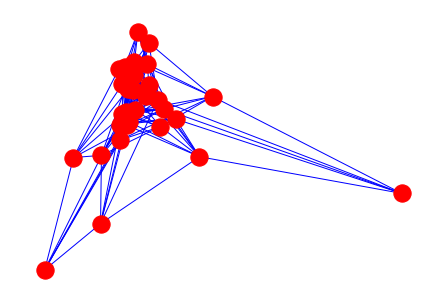

In [48]:
nx.draw(result_graph, pos=nx.spectral_layout(result_graph), node_color='r',edge_color='b')

In [51]:
# new_adjacency_matrix

In [50]:
# connectivity difference
(adjacency_matrix.sum() - new_adjacency_matrix.sum()) / 2

-60.0